<a href="https://colab.research.google.com/github/Farmhouse121/Wilmott-Articles/blob/main/Other_Countries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from datetime import datetime ; DATE_FORMAT,TIME_FORMAT='%m/%d/%Y','%H:%M:%S' ; DATETIME_FORMAT=DATE_FORMAT+" "+TIME_FORMAT
def nprint(*args,**kwargs): print(datetime.now().strftime(TIME_FORMAT),*args,**kwargs)
nprint("Installing yfinance and arch and other stuff...")
from warnings import filterwarnings ; filterwarnings("ignore",category=RuntimeWarning) # I don't care
!pip install arch 1>/dev/null
!pip install yfinance 1>/dev/null
from yfinance import download
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
zero,one,two,three,five,ten,hundred=0e0,1e0,2e0,3e0,5e0,1e1,1e2 # some friendly numbers
half,GoldenRatio=one/two,(one+np.sqrt(five))/two

# import arch classes
from arch.univariate import ConstantMean,ARX,GeneralizedError,Normal,GARCH
from arch.typing import Float64Array

# change the constraints for GeneralizedError
class GeneralizedError2(GeneralizedError):
    """Version of the GED with bounds on fit adjusted to include all feasible distributions (GED is valid for all positive nu values)."""
    def bounds(self,*args)->list[tuple[float,float]]:
        """Revised bounds."""
        return [(0e0,1e2)]

    def constraints(self,*args)->tuple[Float64Array,Float64Array]:
        return np.array([[1], [-1]]), np.array([self.bounds()[0][0],-self.bounds()[0][1]])

# change the constraints for GARCH
class GARCH2(GARCH):
    """Version of GARCH with constraints modified to be more relaxed, leads to models that don't bind on constraints."""
    def bounds(self,resids:Float64Array)->list[tuple[float,float]]:
        """Modify bounds to be more relaxed."""
        v=float(np.mean(abs(resids)**self.power))
        bounds=[(1e-8*v,ten*v)]
        bounds.extend([(-one,two)]*(self.p+self.o+self.q))
        return bounds

    def constraints(self,*args)->tuple[Float64Array,Float64Array]:
        """Modify constraints to permit negative values for A and D etc."""
        a,b=super(GARCH2,self).constraints()
        b[1:(self.p+self.o+1)]=-one
        return a,b

nprint("Done.")

20:14:06 Installing yfinance and arch and other stuff...
20:14:28 Done.


In [ ]:
# get the daily returns of the various market indices
universe=pd.DataFrame({
    "Ticker": ['^GSPC','^HSI','^FTSE','^N225','^FCHI','^GDAXI','^SSMI','^IBEX','^BVSP','^BFX','^AXJO','^STI','^KS11','^GSPTSE','399001.SZ','^TWII'],
    "Name":   ['S&P 500 Index','Hang Seng Index','FTSE-100 Index','Nikkei 225 Index','CAC 40 Index','DAX Index', 'Swiss Markets Index','IBEX 35 Index','Bovespa Index','BEL 20 Index',
               'S&P/ASX 200 Index','STI Index','KOSPI Composite Index','S&P/TSX Composite index','Shenzhen Index','TSEC Weighted Index'],
    "Country":["United States","Hong Kong","United Kingdom","Japan","France","Germany","Switzerland","Spain","Brazil","Belgium","Australia","Singapore","Korea",
               "Canada","China","Taiwan"],
    "Region": ["AMER","APAC","EMEA","APAC","EMEA","EMEA","EMEA","EMEA","LATAM","EMEA","APAC","APAC","APAC","AMER","APAC","APAC"],
    "Start":  ['1928-01-01','1987-01-01','1984-01-01','1965-01-01','1990-01-01','1987-01-01','1990-01-01','1993-01-01',"1993-01-01","1991-04-08",'1992-11-21','1998-01-01',
               '1997-01-01',"1984-12-01","1997-09-01",'1997-08-01'],
    "Zone":  ['US/Eastern','Asia/Hong_Kong','Europe/London','Asia/Tokyo','Europe/Paris','Europe/Berlin','Europe/Zurich','Europe/Madrid','America/Sao_Paulo','Europe/Brussels','Australia/Sydney','Asia/Singapore',
              'Asia/Seoul','America/Toronto','Asia/Shanghai','Asia/Shanghai'],
    "Open":  ['09:30','09:30','08:00','09:00','09:00','09:00','09:00','09:00','10:00','09:00','10:00','09:00','09:00','09:30','09:30','09:30'],
    "Close": ['16:00','16:00','16:30','15:00','17:30','17:30','17:30','17:30','17:55','17:30','16:00','17:00','15:30','16:00','15:00','13:00'],
    "ISO3":  ['USA','HKG','GBR','JPY','FRA','DEU','CHE','ESP','BRA','BEL','AUS','SPG','KOR','CAN','CHN','TWN'],
}).set_index("Ticker").sort_values(["Region","Start"])

for t in 'Open','Close':
    universe[t]=universe[t].apply(pd.Timestamp)

    for i in universe.index:
       universe.loc[i,t]=universe.loc[i,t].tz_localize(universe.loc[i,'Zone'])

data=pd.DataFrame()

for ticker in universe.index[:]:
    nprint(universe.loc[ticker,"Name"],universe.loc[ticker,"Country"])
    df=download(ticker,universe.loc[ticker,"Start"]).dropna()
    df['Daily Return']=df['Adj Close'].pct_change()*hundred
    df['Intraday Return']=df['Close']/df['Open']*hundred-hundred
    df['Overnight Return']=(hundred+df["Daily Return"])/(hundred+df["Intraday Return"])*hundred-hundred
    df.index=pd.DatetimeIndex(df.index).to_period('B')
    df.dropna(inplace=True)
    df.loc[df["Volume"]==0,"Volume"]=np.nan
    universe.loc[ticker,"Start"]=df.index[0]
    universe.loc[ticker,"End"]=df.index[-1]
    universe.loc[ticker,"Sample"]=df["Daily Return"].count()

    for column in df:
        data[(ticker,column)]=df[column]

    data=data.copy()

data.columns=pd.MultiIndex.from_tuples(tuple(data.columns))
universe.columns=pd.MultiIndex.from_tuples(map(lambda x:('Metadata',x),universe.columns))
display(universe)

20:14:41 S&P 500 Index United States
[*********************100%%**********************]  1 of 1 completed
20:14:59 S&P/TSX Composite index Canada
[*********************100%%**********************]  1 of 1 completed
20:14:59 Nikkei 225 Index Japan
[*********************100%%**********************]  1 of 1 completed
20:15:00 Hang Seng Index Hong Kong
[*********************100%%**********************]  1 of 1 completed
20:15:00 S&P/ASX 200 Index Australia
[*********************100%%**********************]  1 of 1 completed
20:15:01 KOSPI Composite Index Korea
[*********************100%%**********************]  1 of 1 completed
20:15:01 TSEC Weighted Index Taiwan
[*********************100%%**********************]  1 of 1 completed
20:15:02 Shenzhen Index China
[*********************100%%**********************]  1 of 1 completed
20:15:02 STI Index Singapore
[*********************100%%**********************]  1 of 1 completed
20:15:02 FTSE-100 Index United Kingdom
[*********************100%%

Metadata                                     \
                              Name         Country Region       Start   
Ticker                                                                  
^GSPC                S&P 500 Index   United States   AMER  1928-01-04   
^GSPTSE    S&P/TSX Composite index          Canada   AMER  1984-12-04   
^N225             Nikkei 225 Index           Japan   APAC  1965-01-06   
^HSI               Hang Seng Index       Hong Kong   APAC  1987-01-05   
^AXJO            S&P/ASX 200 Index       Australia   APAC  1992-11-24   
^KS11        KOSPI Composite Index           Korea   APAC  1997-01-06   
^TWII          TSEC Weighted Index          Taiwan   APAC  1997-08-04   
399001.SZ           Shenzhen Index           China   APAC  1997-09-02   
^STI                     STI Index       Singapore   APAC  1998-01-05   
^FTSE               FTSE-100 Index  United Kingdom   EMEA  1984-01-04   
^GDAXI                   DAX Index         Germany   EMEA  1988-01-04   
^FCHI                 CAC 40 Index          France   EMEA  1990-03-02   
^SSMI          Swiss Markets Index     Switzerland   EMEA  1990-11-12   
^BFX                  BEL 20 Index         Belgium   EMEA  1991-04-10   
^IBEX                IBEX 35 Index           Spain   EMEA  1993-07-13   
^BVSP                Bovespa Index          Brazil  LATAM  1993-04-28   

                                                         \
                        Zone                       Open   
Ticker                                                    
^GSPC             US/Eastern  2023-12-14 09:30:00-05:00   
^GSPTSE      America/Toronto  2023-12-14 09:30:00-05:00   
^N225             Asia/Tokyo  2023-12-14 09:00:00+09:00   
^HSI          Asia/Hong_Kong  2023-12-14 09:30:00+08:00   
^AXJO       Australia/Sydney  2023-12-14 10:00:00+11:00   
^KS11             Asia/Seoul  2023-12-14 09:00:00+09:00   
^TWII          Asia/Shanghai  2023-12-14 09:30:00+08:00   
399001.SZ      Asia/Shanghai  2023-12-14 09:30:00+08:00   
^STI          Asia/Singapore  2023-12-14 09:00:00+08:00   
^FTSE          Europe/London  2023-12-14 08:00:00+00:00   
^GDAXI         Europe/Berlin  2023-12-14 09:00:00+01:00   
^FCHI           Europe/Paris  2023-12-14 09:00:00+01:00   
^SSMI          Europe/Zurich  2023-12-14 09:00:00+01:00   
^BFX         Europe/Brussels  2023-12-14 09:00:00+01:00   
^IBEX          Europe/Madrid  2023-12-14 09:00:00+01:00   
^BVSP      America/Sao_Paulo  2023-12-14 10:00:00-03:00   

                                                                
                               Close ISO3         End   Sample  
Ticker                                                          
^GSPC      2023-12-14 16:00:00-05:00  USA  2023-12-14  24103.0  
^GSPTSE    2023-12-14 16:00:00-05:00  CAN  2023-12-14   9812.0  
^N225      2023-12-14 15:00:00+09:00  JPY  2023-12-14  14496.0  
^HSI       2023-12-14 16:00:00+08:00  HKG  2023-12-14   9123.0  
^AXJO      2023-12-14 16:00:00+11:00  AUS  2023-12-14   7852.0  
^KS11      2023-12-14 15:30:00+09:00  KOR  2023-12-14   6645.0  
^TWII      2023-12-14 13:00:00+08:00  TWN  2023-12-14   6469.0  
399001.SZ  2023-12-14 15:00:00+08:00  CHN  2023-12-14   6370.0  
^STI       2023-12-14 17:00:00+08:00  SPG  2023-12-14   6494.0  
^FTSE      2023-12-14 16:30:00+00:00  GBR  2023-12-14  10092.0  
^GDAXI     2023-12-14 17:30:00+01:00  DEU  2023-12-14   9092.0  
^FCHI      2023-12-14 17:30:00+01:00  FRA  2023-12-14   8580.0  
^SSMI      2023-12-14 17:30:00+01:00  CHE  2023-12-14   8316.0  
^BFX       2023-12-14 17:30:00+01:00  BEL  2023-12-14   8295.0  
^IBEX      2023-12-14 17:30:00+01:00  ESP  2023-12-14   7707.0  
^BVSP      2023-12-14 17:55:00-03:00  BRA  2023-12-14   7583.0

'S&P/ASX 200, Nikkei 225, KOSPI Composite, STI, Hang Seng, TSEC Weighted, Shenzhen, FTSE-100, DAX, CAC 40, Swiss Markets, BEL 20, IBEX 35, Bovespa, S&P 500, S&P/TSX Composite index'

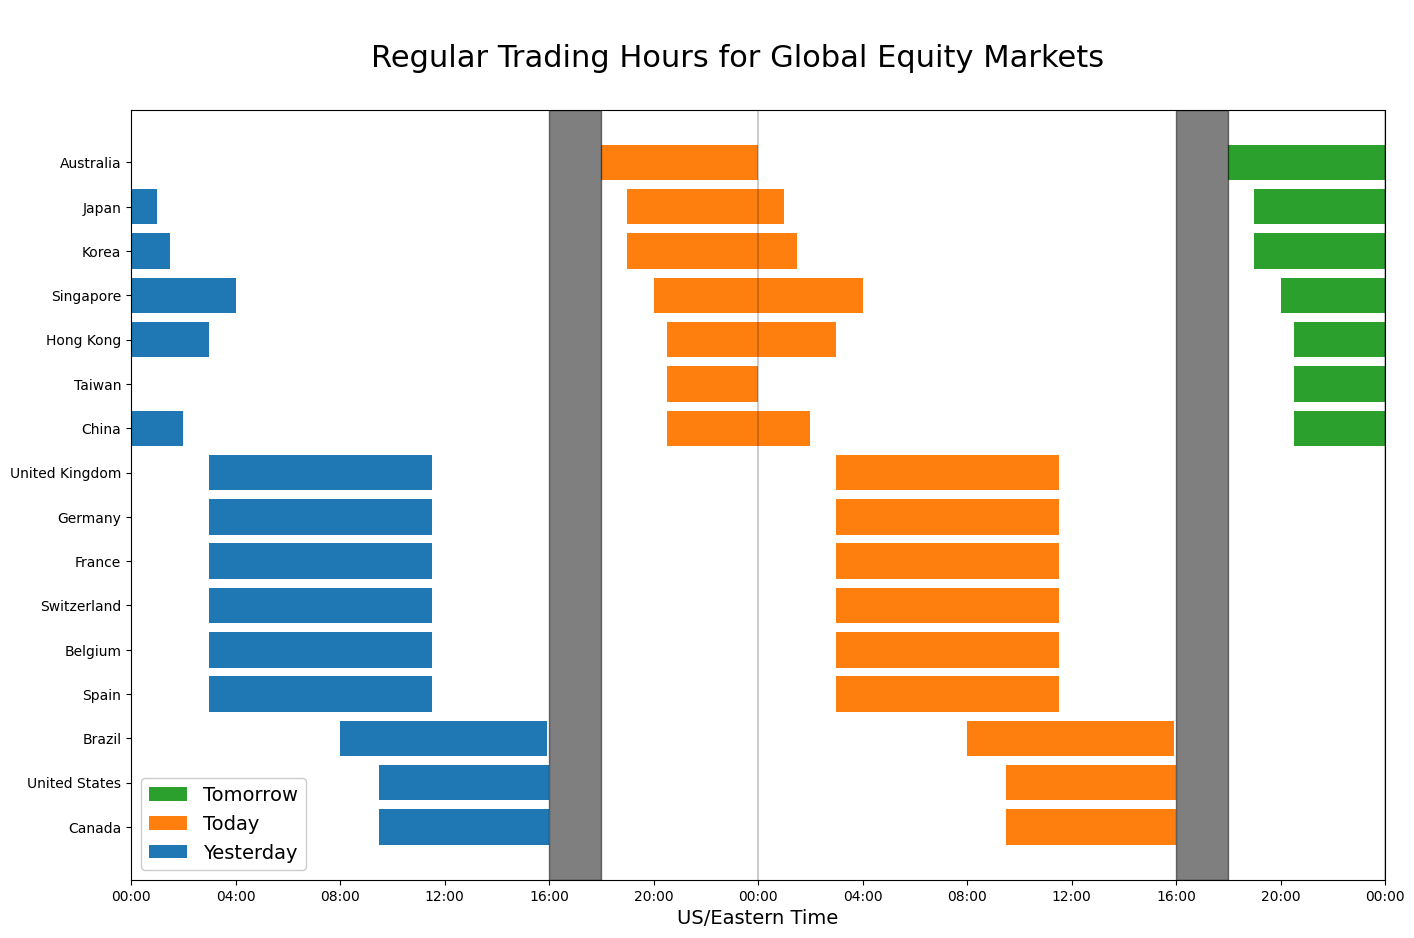

In [ ]:
from matplotlib.dates import DateFormatter

viewpoint,vpoffset=universe.loc['^GSPC',("Metadata","Zone")],universe.loc['^GSPC',("Metadata","Open")].utcoffset()
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
design=universe[[('Metadata','Country'),('Metadata','Open'),('Metadata','Close')]].copy()
design.columns=pd.MultiIndex.from_tuples([('Country',""),('Local','Open'),('Local','Close')])

for c in 'Open','Close':
    design[('New York',c)]=design[('Local',c)].apply(lambda x:x.tz_convert(viewpoint))

design.sort_values(('New York','Open'),inplace=True)
day_start,day_end=pd.Timestamp('00:00').tz_localize(viewpoint)-pd.Timedelta("1 day 5 hour"),pd.Timestamp('00:00').tz_localize(viewpoint)+pd.Timedelta("19 hour 1 sec")

for offset in 1,0,-1:
    plot.barh(design["Country"],design[('New York','Close')]+pd.Timedelta("%d day" % offset)+vpoffset,color="C%d" % (offset+1),label=['Yesterday','Today','Tomorrow'][offset+1])
    plot.barh(design["Country"],design[('New York','Open')]+pd.Timedelta("%d day" % offset)+vpoffset,color="white")
    plot.axvline(pd.Timestamp("00:00")+pd.Timedelta("%d day" % offset),color='black',alpha=0.2)

plot.set_xlim(day_start,day_end)
plot.xaxis.set_major_formatter(DateFormatter("%H:%M"))
plot.xaxis.set_ticks(np.arange(*plot.get_xlim(),4e0/24e0))
plot.invert_yaxis()
plot.set_xlabel(viewpoint+" Time",fontsize=14)
plot.legend(fontsize=14,loc='lower left',framealpha=1)

for offset in 0,1:
    plot.axvspan(
        design.loc['^GSPC',('Local','Close')]+pd.Timedelta("%d day"% (offset-1))+vpoffset,
        design.loc['^AXJO',('Local','Open')]+pd.Timedelta("%d day" % offset)+vpoffset,
        color='black',
        alpha=0.5
      )

title="Regular Trading Hours for Global Equity Markets"
figure.suptitle("\n"+title,fontsize=22)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')
", ".join(universe.sort_values(("Metadata","Open"))[("Metadata","Name")].apply(lambda x:x.replace(" Index","")))

20:15:32 Computing variance ratios for daytime and nighttime returns for [2000,2023].


Variance                              Ratio                     \
              Daily  Intraday Overnight Intraday:Daily Overnight:Intraday   
Ticker                                                                      
^GSPC      1.304552  0.779803  0.294746      59.775482          37.797477   
^GSPTSE    0.884641  0.480757  0.288045      54.344885          59.914863   
^N225      1.529947  0.687947  0.559807      44.965405          81.373645   
^HSI       1.823194  0.969823  0.770251      53.193617          79.421789   
^AXJO      0.949959  0.867189  0.024975      91.286993           2.880047   
^KS11      1.177060  0.797337  0.419477      67.739715          52.609737   
^TWII      0.925361  0.552227  0.206801      59.676916          37.448590   
399001.SZ  1.655792  1.410573  0.282091      85.190240          19.998306   
^STI       0.635195  0.338713  0.222672      53.324268          65.740450   
^FTSE      0.912387  0.911328  0.000304      99.883846           0.033402   
^GDAXI     1.332327  0.785970  0.531289      58.992240          67.596678   
^FCHI      1.268909  0.763519  0.468423      60.171276          61.350567   
^SSMI      0.736362  0.537367  0.182185      72.975852          33.903216   
^BFX       1.100493  0.703669  0.387649      63.941219          55.089626   
^IBEX      1.365598  0.924924  0.414747      67.730338          44.841156   
^BVSP      2.226203  2.202746  0.011928      98.946314           0.541504   

           Levene Test                                   Index         
             Statistic        p Value                     Name Region  
Ticker                                                                 
^GSPC       190.358070   1.392906e-41            S&P 500 Index   AMER  
^GSPTSE      97.720478   1.422145e-22  S&P/TSX Composite index   AMER  
^N225         0.020762   8.854423e-01         Nikkei 225 Index   APAC  
^HSI         18.629725   1.658051e-05          Hang Seng Index   APAC  
^AXJO       603.208522  7.776123e-118        S&P/ASX 200 Index   APAC  
^KS11        39.567119   3.816908e-10    KOSPI Composite Index   APAC  
^TWII       157.741314   5.516783e-35      TSEC Weighted Index   APAC  
399001.SZ   407.141281   3.619556e-83           Shenzhen Index   APAC  
^STI         32.124549   1.637012e-08                STI Index   APAC  
^FTSE       890.308244  2.098075e-164           FTSE-100 Index   EMEA  
^GDAXI       40.016973   3.044197e-10                DAX Index   EMEA  
^FCHI        55.735424   1.190558e-13             CAC 40 Index   EMEA  
^SSMI       113.345745   7.692408e-26      Swiss Markets Index   EMEA  
^BFX         78.347993   1.745367e-18             BEL 20 Index   EMEA  
^IBEX       133.597073   4.902152e-30            IBEX 35 Index   EMEA  
^BVSP      1122.518571  5.552936e-199            Bovespa Index  LATAM

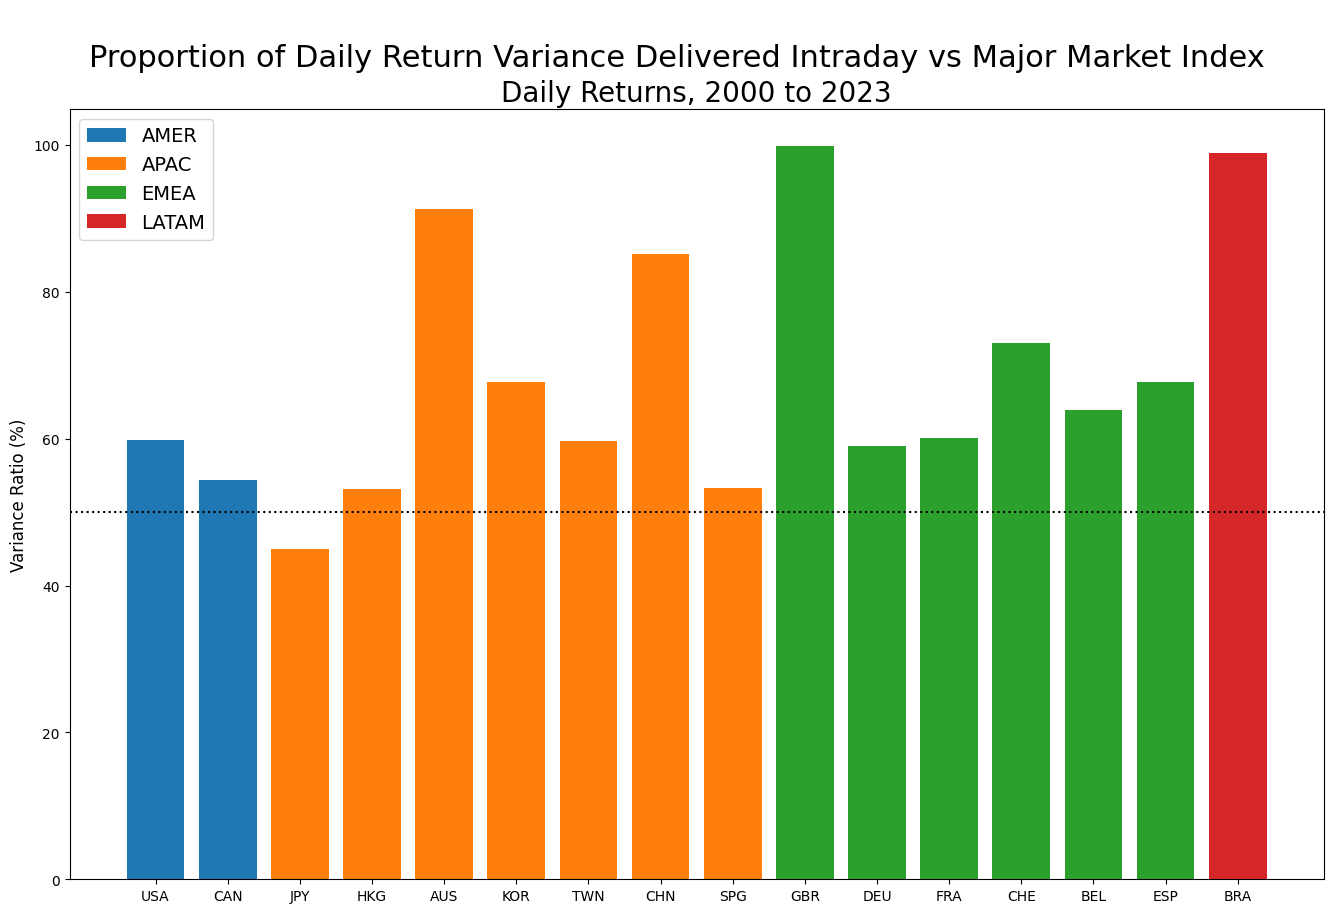

In [ ]:
from scipy.stats import levene as variance_test
fyear,lyear=2000,datetime.now().year
nprint("Computing variance ratios for daytime and nighttime returns for [%d,%d]." % (fyear,lyear))

results=pd.DataFrame({"Ticker":[],("Variance","Daily"):[],("Variance","Intraday"):[],("Variance","Overnight"):[]}).set_index("Ticker")
results.columns=pd.MultiIndex.from_tuples(tuple(results.columns))

for ticker in universe.index:
    design=data[(data.index.year>=fyear) & (data.index.year<=lyear)].dropna().copy()

    for period in "Daily","Intraday","Overnight":
      results.loc[ticker,("Variance",period)]=design[(ticker,period+" Return")].var()

    tr=variance_test(design[(ticker,"Intraday Return")],design[(ticker,"Overnight Return")])
    results.loc[ticker,("Levene Test","Statistic")]=tr.statistic
    results.loc[ticker,("Levene Test","p Value")]=tr.pvalue

results[("Ratio","Intraday:Daily")]=results[("Variance","Intraday")]/results[("Variance","Daily")]*hundred
results[("Ratio","Overnight:Intraday")]=results[("Variance","Overnight")]/results[("Variance","Intraday")]*hundred
results=results[sorted(tuple(results.columns),key=lambda x:1 if x[0]=="Variance" else 2 if x[0]=="Ratio" else 3)].copy() # just changing column order
results[("Index","Name")]=universe[("Metadata","Name")]
results[("Index","Region")]=universe[("Metadata","Region")]
display(results)

figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))

for region in "AMER","APAC","EMEA","LATAM":
    plot.bar(universe[universe[("Metadata","Region")]==region][("Metadata","ISO3")],results[universe[("Metadata","Region")]==region][("Ratio","Intraday:Daily")],label=region)

title="Proportion of Daily Return Variance Delivered Intraday vs Major Market Index"
figure.suptitle("\n"+title,fontsize=22)
plot.set_title("Daily Returns, %d to %d" % (fyear,lyear),fontsize=20)
plot.legend(fontsize=14)
plot.set_ylabel("Variance Ratio (%)",fontsize=12)
plot.axhline(hundred/two,color='black',linestyle=':')
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

20:35:50 Daily Return


,^GSPC,^GSPTSE,^N225,^HSI,^AXJO,^KS11,^TWII,399001.SZ,^STI,^FTSE,^GDAXI,^FCHI,^SSMI,^BFX,^IBEX,^BVSP
^GSPC,1.000000,0.739787,0.122793,0.192678,0.178174,0.155639,0.124368,0.066538,0.224087,0.496000,0.529995,0.525822,0.471407,0.497822,0.494666,0.495287
^GSPTSE,0.739787,1.000000,0.226117,0.264040,0.272414,0.202947,0.181125,0.103458,0.295457,0.541857,0.505392,0.522048,0.467520,0.480719,0.497137,0.475952
^N225,0.122793,0.226117,1.000000,0.445831,0.522984,0.482061,0.448930,0.199664,0.482864,0.303415,0.270011,0.294284,0.294966,0.277822,0.266435,0.126277
^HSI,0.192678,0.264040,0.445831,1.000000,0.519289,0.493007,0.465130,0.353482,0.666577,0.355929,0.325008,0.341790,0.328245,0.332516,0.317443,0.197253
^AXJO,0.178174,0.272414,0.522984,0.519289,1.000000,0.444277,0.435022,0.212184,0.506957,0.343876,0.283803,0.315813,0.318306,0.322632,0.307707,0.174411
^KS11,0.155639,0.202947,0.482061,0.493007,0.444277,1.000000,0.482940,0.173668,0.492483,0.283885,0.262270,0.268872,0.245500,0.247683,0.240044,0.190807
^TWII,0.124368,0.181125,0.448930,0.465130,0.435022,0.482940,1.000000,0.209463,0.459727,0.233432,0.216492,0.235851,0.224104,0.222904,0.210756,0.145782
399001.SZ,0.066538,0.103458,0.199664,0.353482,0.212184,0.173668,0.209463,1.000000,0.221643,0.106933,0.092440,0.102810,0.084406,0.122540,0.084474,0.088664
^STI,0.224087,0.295457,0.482864,0.666577,0.506957,0.492483,0.459727,0.221643,1.000000,0.403132,0.348036,0.384835,0.358733,0.373792,0.358020,0.255554
^FTSE,0.496000,0.541857,0.303415,0.355929,0.343876,0.283885,0.233432,0.106933,0.403132,1.000000,0.758552,0.837196,0.763848,0.758466,0.765660,0.366766


20:35:51 Overnight Return


,^GSPC,^GSPTSE,^N225,^HSI,^AXJO,^KS11,^TWII,399001.SZ,^STI,^FTSE,^GDAXI,^FCHI,^SSMI,^BFX,^IBEX,^BVSP
^GSPC,1.000000,0.477751,-0.000475,0.085692,0.006440,0.011305,0.030160,0.041405,0.122270,0.003403,0.316572,0.306691,0.196257,0.286192,0.340120,0.007476
^GSPTSE,0.477751,1.000000,0.178621,0.238571,0.159272,0.087318,0.166028,0.086588,0.137119,0.178737,0.344558,0.451789,0.356725,0.399772,0.409449,0.098524
^N225,-0.000475,0.178621,1.000000,0.518690,0.252351,0.356456,0.538097,0.348539,0.509586,0.166364,0.265373,0.349653,0.384939,0.369024,0.360697,0.012950
^HSI,0.085692,0.238571,0.518690,1.000000,0.409406,0.369077,0.631851,0.428722,0.565232,0.190190,0.322969,0.471013,0.442251,0.482420,0.420264,0.080011
^AXJO,0.006440,0.159272,0.252351,0.409406,1.000000,0.192239,0.344577,0.181334,0.243137,0.345125,0.248509,0.288966,0.196728,0.292925,0.218385,0.154778
^KS11,0.011305,0.087318,0.356456,0.369077,0.192239,1.000000,0.389026,0.184623,0.322060,0.014164,0.150153,0.233180,0.233751,0.222759,0.201610,-0.006303
^TWII,0.030160,0.166028,0.538097,0.631851,0.344577,0.389026,1.000000,0.325513,0.512183,0.068510,0.263666,0.392146,0.375857,0.382376,0.325172,0.068629
399001.SZ,0.041405,0.086588,0.348539,0.428722,0.181334,0.184623,0.325513,1.000000,0.234523,0.002662,0.182392,0.188606,0.179293,0.234617,0.182069,0.004219
^STI,0.122270,0.137119,0.509586,0.565232,0.243137,0.322060,0.512183,0.234523,1.000000,0.112558,0.290759,0.412698,0.361248,0.371702,0.339205,0.034865
^FTSE,0.003403,0.178737,0.166364,0.190190,0.345125,0.014164,0.068510,0.002662,0.112558,1.000000,0.304979,0.290608,0.093006,0.238618,0.137922,0.079655


20:35:52 Intraday Return


,^GSPC,^GSPTSE,^N225,^HSI,^AXJO,^KS11,^TWII,399001.SZ,^STI,^FTSE,^GDAXI,^FCHI,^SSMI,^BFX,^IBEX,^BVSP
^GSPC,1.000000,0.649740,0.119674,0.188332,0.146092,0.155482,0.133549,0.046711,0.203115,0.444282,0.505212,0.490587,0.439418,0.455779,0.450595,0.470372
^GSPTSE,0.649740,1.000000,0.022198,0.076068,0.106040,0.047174,0.050236,0.024554,0.077196,0.300512,0.301812,0.320853,0.288325,0.318309,0.284127,0.379165
^N225,0.119674,0.022198,1.000000,0.272167,0.344619,0.349037,0.242627,0.114126,0.357719,0.220551,0.067650,0.015999,0.070424,0.015116,0.065481,0.124652
^HSI,0.188332,0.076068,0.272167,1.000000,0.169363,0.328121,0.311270,0.302239,0.468547,0.224308,0.139618,0.078066,0.127408,0.089015,0.118291,0.168129
^AXJO,0.146092,0.106040,0.344619,0.169363,1.000000,0.209373,0.202892,0.117561,0.306958,0.334881,0.074351,0.042836,0.076772,0.065606,0.080669,0.157165
^KS11,0.155482,0.047174,0.349037,0.328121,0.209373,1.000000,0.357211,0.127113,0.331936,0.168371,0.091517,0.040656,0.042617,0.044939,0.063661,0.177237
^TWII,0.133549,0.050236,0.242627,0.311270,0.202892,0.357211,1.000000,0.152506,0.284458,0.123065,0.052683,0.030087,0.049412,0.033033,0.029818,0.156792
399001.SZ,0.046711,0.024554,0.114126,0.302239,0.117561,0.127113,0.152506,1.000000,0.140556,0.065186,-0.018649,-0.032124,-0.030493,0.003717,-0.024245,0.076547
^STI,0.203115,0.077196,0.357719,0.468547,0.306958,0.331936,0.284458,0.140556,1.000000,0.329220,0.189583,0.147928,0.143626,0.146459,0.182381,0.251111
^FTSE,0.444282,0.300512,0.220551,0.224308,0.334881,0.168371,0.123065,0.065186,0.329220,1.000000,0.658539,0.650973,0.593243,0.591189,0.613793,0.345512


,Correlation,N*,N-N*,N*/N
Period,,,,
Daily Return,33.038033,2.686500,13.313500,0.167906
Overnight Return,25.800827,3.285337,12.714663,0.205334
Intraday Return,17.980899,4.327675,11.672325,0.270480


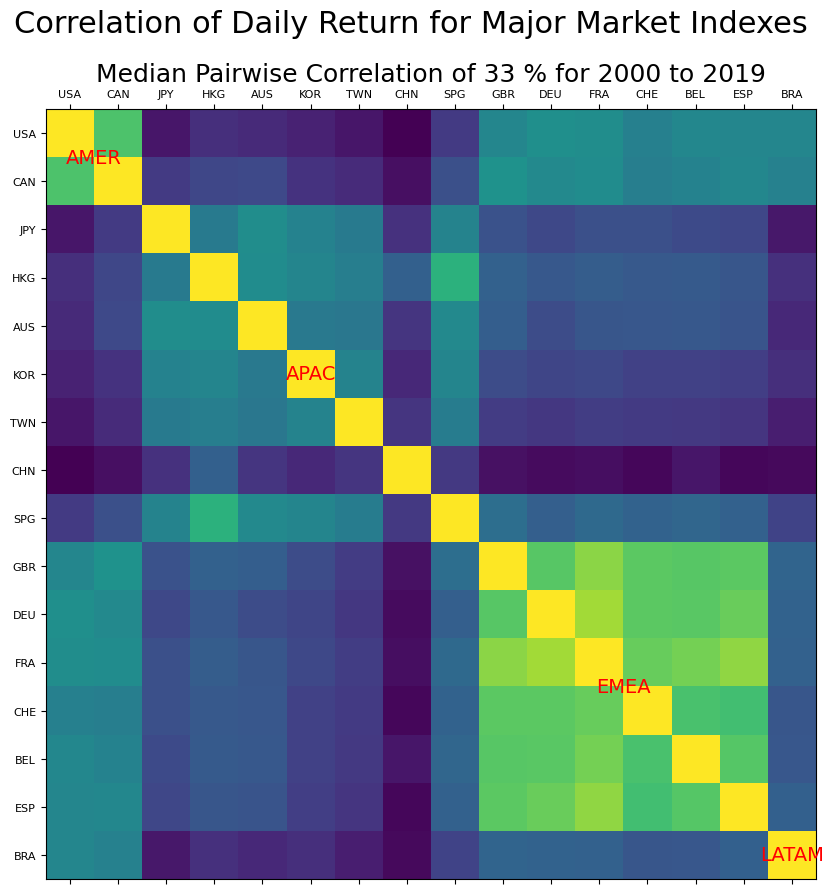

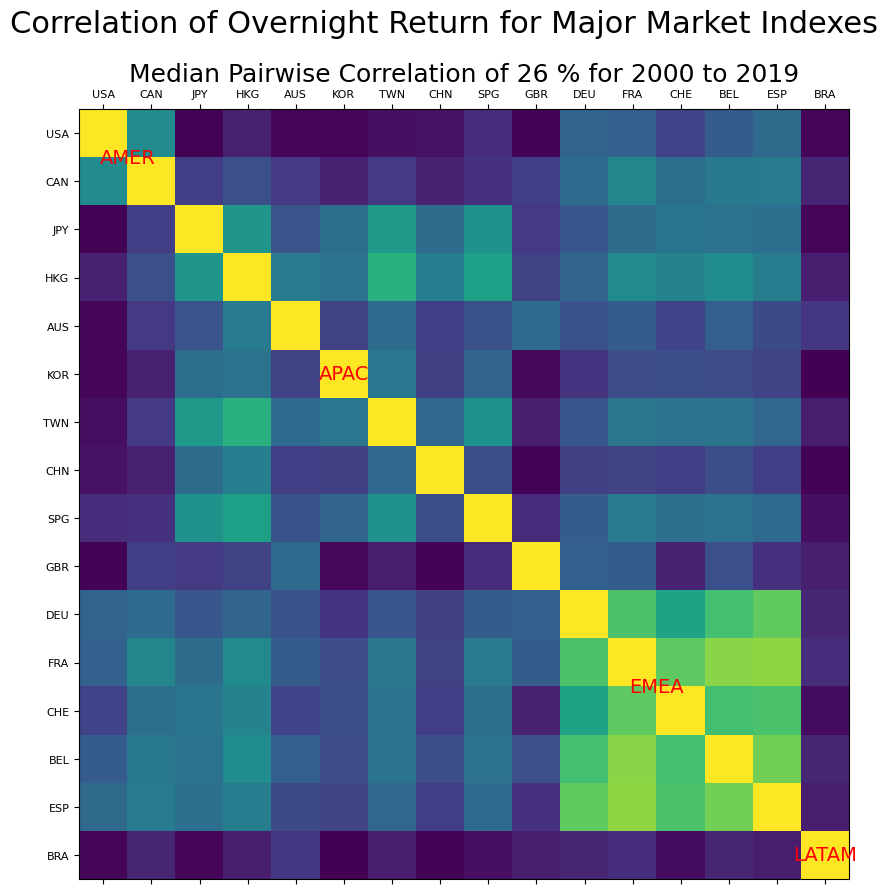

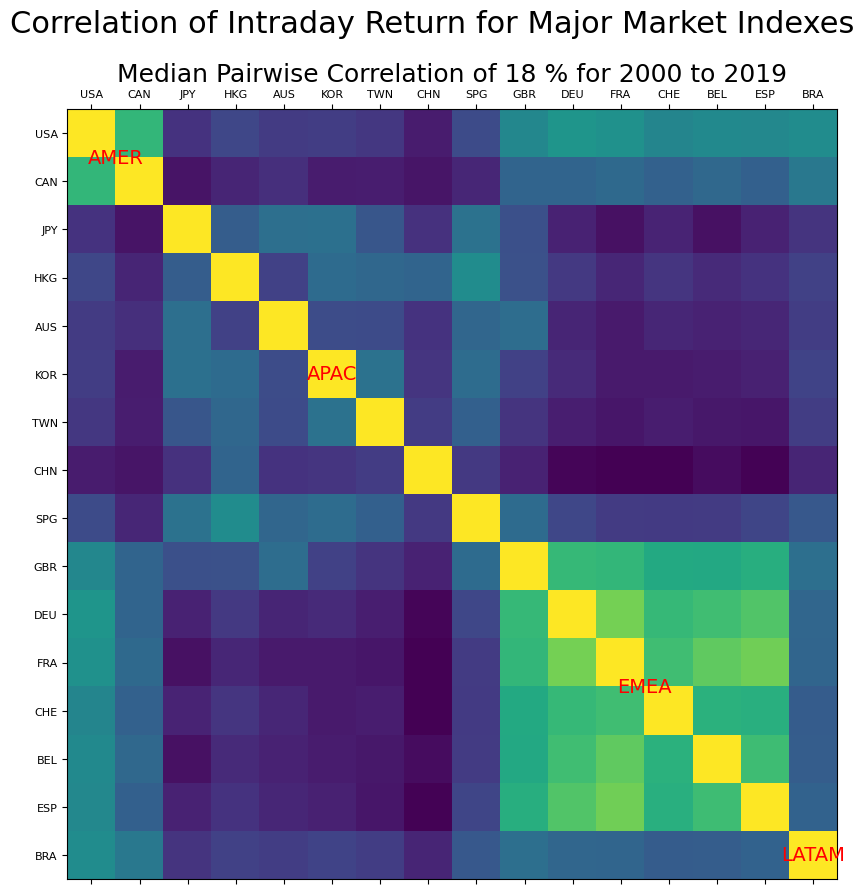

In [ ]:
rf=pd.DataFrame({'Period':[],'Correlation':[]}).set_index("Period")

for feature in 'Daily Return','Overnight Return','Intraday Return':
    nprint(feature)
    rho=data.xs(feature,axis=1,level=1).corr()
    display(rho)
    np.median([1,2,3])

    figure,plot=pl.subplots(figsize=(10*GoldenRatio,10))
    plot.matshow(rho)
    plot.set_xticks(range(0,rho.shape[0]),universe.loc[rho.index,('Metadata','ISO3')],fontsize=8)
    plot.set_yticks(range(0,rho.shape[1]),universe.loc[rho.index,('Metadata','ISO3')],fontsize=8)

    for pos,label in [(0.5,'AMER'),(5,'APAC'),(11.5,'EMEA'),(15,'LATAM')]:
        plot.text(pos,pos,label,color='red',fontsize=14,horizontalalignment='center',verticalalignment='center')

    rf.loc[feature,"Correlation"]=np.median(np.array(rho)[np.triu_indices(rho.shape[0],k=1)])*hundred

    title="Correlation of %s for Major Market Indexes" % feature
    figure.suptitle(title,fontsize=22)
    plot.set_title("Median Pairwise Correlation of %.0f %% for %d to %d" % (rf.loc[feature,"Correlation"],fyear,lyear),fontsize=18)
    figure.savefig(title+".png",dpi=300,bbox_inches='tight')

rf['N*']=rho.shape[0]/(one+(rho.shape[0]-one)*rf['Correlation']/hundred)
rf['N-N*']=rho.shape[0]-rf['N*']
rf['N*/N']=rf['N*']/rho.shape[0]
display(rf)

In [ ]:
# fit symmetric and asymmetric GARCH models using arch package GARCH process and extended GED distribution
feature='Daily Return'
style,fyear,lyear='GJR-GARCH-AR(1)',2000,2019
nprint("Fitting %s with %s with GED for %d-%d." % (feature,style,fyear,lyear))
from scipy.stats import chi2 as density
from tqdm.notebook import tqdm

for ticker in tqdm(universe.index):
    design=data[ticker].copy().dropna()

    if design[feature].count()>252:
        model=ARX(design.loc[(design.index.year>=fyear)&(design.index.year<=lyear),feature],lags=[1])
        model.volatility = GARCH2(1, 1, 1)
        model.distribution = GeneralizedError2()
        fit=model.fit(update_freq=0,disp='off',show_warning=False)

        if fit.optimization_result.success:
            universe.loc[ticker,(style,'sample')]=fit.nobs
            universe.loc[ticker,(style,'drift')]=fit.params[0]
            universe.loc[ticker,(style,'autocorrelation')]=fit.params[1]
            universe.loc[ticker,(style,'quiescent')]=fit.params[2]
            universe.loc[ticker,(style,'stimulus')]=fit.params[3]
            universe.loc[ticker,(style,'memory')]=fit.params[5]
            universe.loc[ticker,(style,'downside')]=fit.params[4]
            universe.loc[ticker,(style,'shape')]=one/fit.params[6]
            data[(ticker,'Volatility')]=fit.conditional_volatility
            data[(ticker,'Innovation')]=(data[(ticker,feature)]-fit.params[0]-fit.params[1]*data[(ticker,feature)].shift())/data[(ticker,'Volatility')]

        else:
            nprint("Regression failed for %s." % ticker)

    else:
        nprint("Insufficient observations for %s." % ticker)

xf=universe.xs(style,axis=1,level=0).set_index(universe[('Metadata','Country')])
xf.index.names=["Country"]
display(xf)
#xf.to_latex()

22:16:34 Fitting Daily Return with GJR-GARCH-AR(1) with GED for 2000-2019.


  0%|          | 0/16 [00:00<?, ?it/s]

22:16:35 Regression failed for ^AXJO.


,sample,drift,autocorrelation,quiescent,stimulus,memory,downside,shape
Country,,,,,,,,
United States,5018.0,0.049669,-0.055487,0.016925,-0.012570,0.891375,0.206321,0.723481
Canada,4808.0,0.034521,0.024357,0.007547,0.018964,0.918147,0.099627,0.629452
Japan,3936.0,0.040613,-0.026507,0.047513,0.034359,0.872725,0.131153,0.699946
Hong Kong,4246.0,0.044031,-0.005797,0.017568,0.017421,0.933522,0.072590,0.703682
Australia,582.0,0.615113,0.308455,0.010044,-0.082823,1.012047,0.067258,0.507633
Korea,4574.0,0.051846,-0.006752,0.010805,0.031605,0.922824,0.077091,0.729238
Taiwan,3909.0,0.044973,0.014535,0.011081,0.014862,0.939983,0.064431,0.758094
China,3631.0,0.032398,-0.010846,0.021286,0.046823,0.938167,0.017393,0.756443
Singapore,3237.0,0.021872,-0.012867,0.011729,0.053931,0.894358,0.078398,0.681336


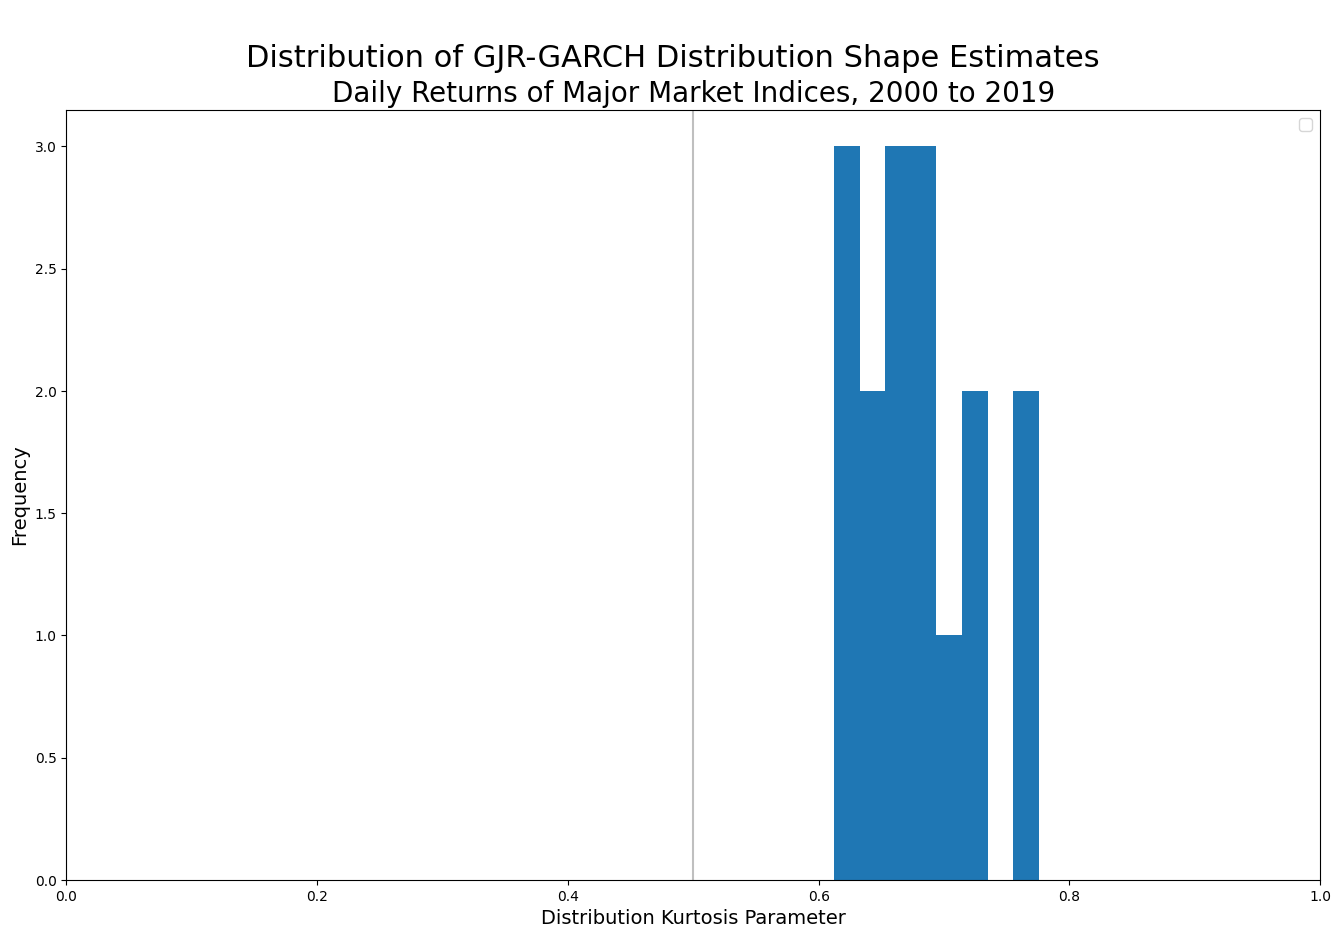

In [ ]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))

#for region in set(universe[('Metadata','Region')]):
#    tickers=universe.index[universe[('Metadata','Region')]==region]
#    samples,bins,patches=plot.hist(universe.xs(style,axis=1,level=0).loc[tickers,'shape'],bins=np.linspace(zero,one,50),alpha=0.25,label=region)
samples,bins,patches=plot.hist(universe.xs(style,axis=1,level=0)['shape'],bins=np.linspace(zero,one,50))
plot.set_xlim(zero,one)
plot.axvline(half,color="black",alpha=0.25)
plot.set_xlabel("Distribution Kurtosis Parameter",fontsize=14)
plot.set_ylabel("Frequency",fontsize=14)
plot.legend(fontsize=12)
title="Distribution of GJR-GARCH Distribution Shape Estimates"
figure.suptitle("\n"+title,fontsize=22)
plot.set_title("%ss of Major Market Indices, %d to %d" % (feature,fyear,lyear),fontsize=20)
plot.axvline(color='black',alpha=0.2)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

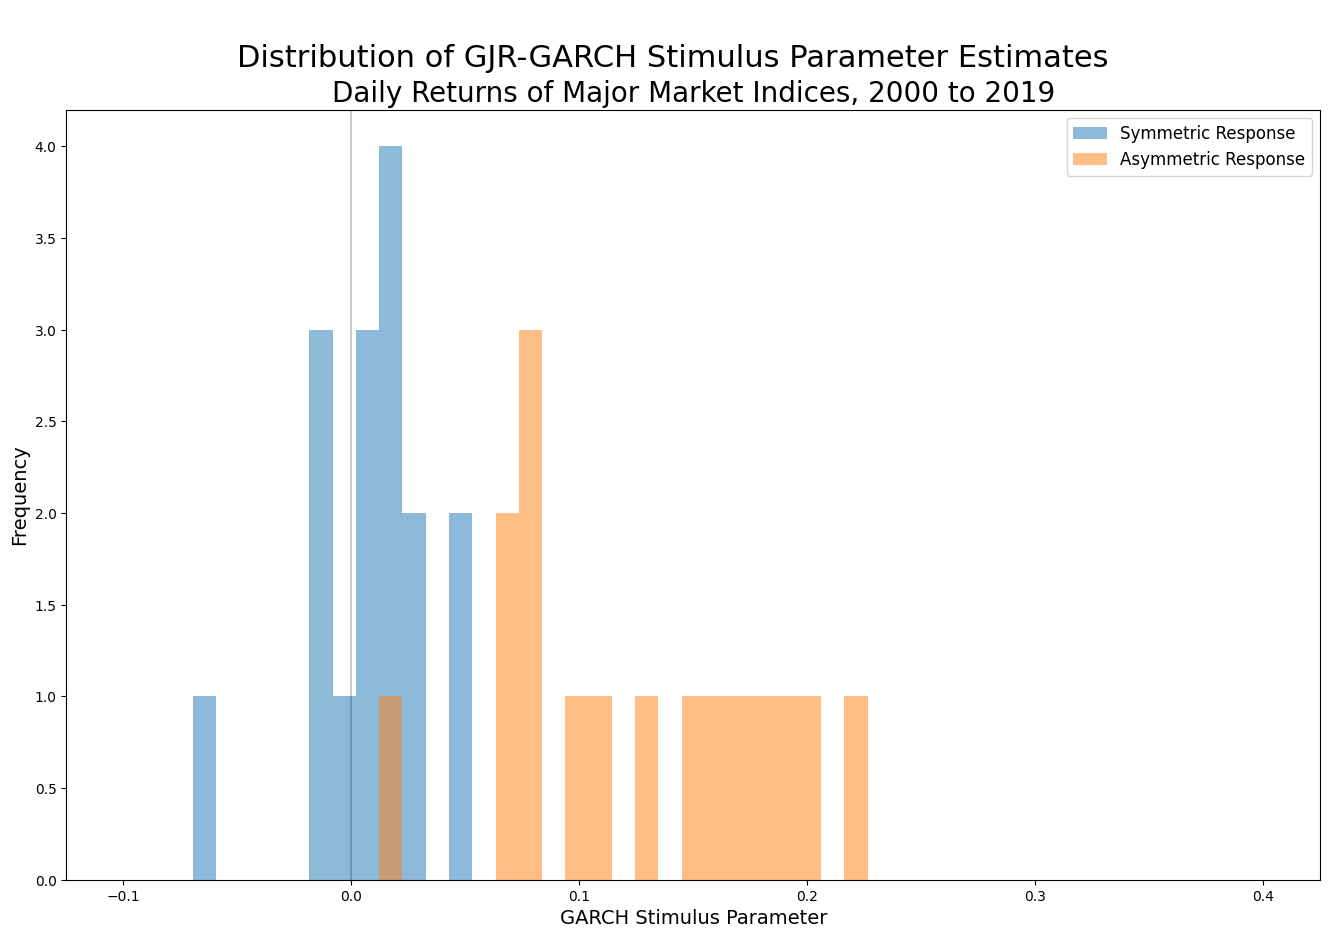

In [ ]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
samples,bins,patches=plot.hist(universe.xs(style,axis=1,level=0)['stimulus'],bins=np.linspace(-0.1,0.4,50),alpha=0.5,label='Symmetric Response')
plot.hist(universe.xs(style,axis=1,level=0)['downside'],bins=bins,alpha=0.5,label='Asymmetric Response')
plot.set_xlabel("GARCH Stimulus Parameter",fontsize=14)
plot.set_ylabel("Frequency",fontsize=14)
plot.legend(fontsize=12)
title="Distribution of GJR-GARCH Stimulus Parameter Estimates"
figure.suptitle("\n"+title,fontsize=22)
plot.set_title("%ss of Major Market Indices, %d to %d" % (feature,fyear,lyear),fontsize=20)
plot.axvline(color='black',alpha=0.2)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

In [ ]:
from scipy.stats import ttest_1samp as ttest,t as density
results=pd.DataFrame({("Variable",""):[],("Tested","Mean"):[],("Sample","Mean"):[],("Sample","St.Dev."):[],("Nominal","t Statistic"):[],("Nominal","p Value"):[]}).set_index("Variable")
results.columns=pd.MultiIndex.from_tuples(results.columns)
study_group=universe.index #['^GSPC','^N225','399001.SZ','^FTSE','^BVSP']

display(rho.loc[study_group,study_group])

for variable in 'stimulus','downside','shape':
    sample=universe[universe.index.isin(study_group)].xs(style,axis=1,level=0)[variable]
    vname="Symmetric Response" if variable=='stimulus' else "Asymmetric Response" if variable=='downside' else 'Distribution Shape'
    results.loc[vname,("Tested","Mean")]=half if variable=='shape' else zero
    results.loc[vname,("Sample","Mean")]=sample.mean()
    results.loc[vname,("Sample","St.Dev.")]=sample.std()
    test_results=ttest(sample,results.loc[vname,("Tested","Mean")])
    results.loc[vname,("Nominal","t Statistic")]=test_results.statistic
    results.loc[vname,("Nominal","p Value")]=test_results.pvalue

results[("Nominal","Significance")]=results[("Nominal","p Value")].apply(lambda x:'***' if x<0.001 else '**' if x<0.01 else '*' if x<0.05 else '')
results[("Adjusted","t* Statistic")]=results[("Nominal","t Statistic")]*np.sqrt(rf.loc[feature,"N*/N"])
results[("Adjusted","p* Value")]=one-density(rf.loc[feature,"N*"]-one).cdf(results[("Adjusted","t* Statistic")])
results[("Nominal","Significance*")]=results[("Adjusted","p* Value")].apply(lambda x:'***' if x<0.001 else '**' if x<0.01 else '*' if x<0.05 else '')
print("t Test for Canonical Mean in Parameter Estimates (n.b. p Values likely biased downwards due to cross-correlation of time-series)")
display(results)

Ticker,^GSPC,^GSPTSE,^N225,^HSI,^AXJO,^KS11,^TWII,399001.SZ,^STI,^FTSE,^GDAXI,^FCHI,^SSMI,^BFX,^IBEX,^BVSP
Ticker,,,,,,,,,,,,,,,,
^GSPC,1.000000,0.649740,0.119674,0.188332,0.146092,0.155482,0.133549,0.046711,0.203115,0.444282,0.505212,0.490587,0.439418,0.455779,0.450595,0.470372
^GSPTSE,0.649740,1.000000,0.022198,0.076068,0.106040,0.047174,0.050236,0.024554,0.077196,0.300512,0.301812,0.320853,0.288325,0.318309,0.284127,0.379165
^N225,0.119674,0.022198,1.000000,0.272167,0.344619,0.349037,0.242627,0.114126,0.357719,0.220551,0.067650,0.015999,0.070424,0.015116,0.065481,0.124652
^HSI,0.188332,0.076068,0.272167,1.000000,0.169363,0.328121,0.311270,0.302239,0.468547,0.224308,0.139618,0.078066,0.127408,0.089015,0.118291,0.168129
^AXJO,0.146092,0.106040,0.344619,0.169363,1.000000,0.209373,0.202892,0.117561,0.306958,0.334881,0.074351,0.042836,0.076772,0.065606,0.080669,0.157165
^KS11,0.155482,0.047174,0.349037,0.328121,0.209373,1.000000,0.357211,0.127113,0.331936,0.168371,0.091517,0.040656,0.042617,0.044939,0.063661,0.177237
^TWII,0.133549,0.050236,0.242627,0.311270,0.202892,0.357211,1.000000,0.152506,0.284458,0.123065,0.052683,0.030087,0.049412,0.033033,0.029818,0.156792
399001.SZ,0.046711,0.024554,0.114126,0.302239,0.117561,0.127113,0.152506,1.000000,0.140556,0.065186,-0.018649,-0.032124,-0.030493,0.003717,-0.024245,0.076547
^STI,0.203115,0.077196,0.357719,0.468547,0.306958,0.331936,0.284458,0.140556,1.000000,0.329220,0.189583,0.147928,0.143626,0.146459,0.182381,0.251111


t Test for Canonical Mean in Parameter Estimates (n.b. p Values likely biased downwards due to cross-correlation of time-series)


Tested    Sample               Nominal                \
                      Mean      Mean   St.Dev. t Statistic       p Value   
Variable                                                                   
Symmetric Response     0.0  0.008768  0.028633    1.224891  2.395044e-01   
Asymmetric Response    0.0  0.125551  0.059704    8.411642  4.616877e-07   
Distribution Shape     0.5  0.680570  0.046417   15.560753  1.155029e-10   

                                     Adjusted                 Nominal  
                    Significance t* Statistic  p* Value Significance*  
Variable                                                               
Symmetric Response                   0.637037  0.282623                
Asymmetric Response          ***     4.374699  0.008893            **  
Distribution Shape           ***     8.092784  0.001335            **